In [60]:
import pandas as pd
import pickle
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import linregress

In [2]:
suffix = 'calendar_grosses_domestic_2023'

with open(f'rt_df_{suffix}.pkl', 'rb') as file:
    # Load the pickled object
    rt_raw = pickle.load(file)

with open(f'mojo_{suffix}.pkl', 'rb') as file:
    # Load the pickled object
    mojo_raw = pickle.load(file)


In [3]:
rt = rt_raw.copy()

In [5]:
len(rt)

162

In [4]:
mojo = mojo_raw.copy()

In [8]:
mojo = mojo[ ~( mojo['Release'].str.contains('re-release', case = False) | mojo['Release'].str.contains('anniversary', case = False) ) ]
mojo = mojo.drop(['Genre', 'Budget', 'Running Time'], axis = 1).rename(columns = {'Release':'movie_title'})
mojo.columns = [x.lower() for x in mojo.columns]
mojo[['gross', 'total gross']] = mojo[['gross', 'total gross']].apply(lambda x: x.str.replace(',', '').str.replace('$', ''))
mojo[['gross', 'total gross']] = mojo[['gross', 'total gross']].apply(lambda x: pd.to_numeric(x, errors='coerce'))


In [9]:
rt = rt.drop(['image', 'critics_consensus', 'rating', 'actors', 'genres', 'directors', 'synopsis'], axis = 1)

In [13]:
print(rt.columns)
mojo.columns
print(len(mojo))
len(rt)
mojo[mojo['movie_title'].str.contains('Emily')]

Index(['movie_title', 'tomatometer', 'audience_score', 'weighted_score',
       'duration', 'year_released', 'url', 'num_of_reviews'],
      dtype='object')
189


,rank,movie_title,gross,theaters,total gross,release date,distributor,estimated
195,196,Emily,1097067,579,1097067,Feb 17,Bleecker Street Media,False


In [14]:
## manually make some mappings
rt.loc[rt['movie_title'] == 'Ant-Man and The Wasp: Quantumania', 'movie_title'] = 'Ant-Man and the Wasp: Quantumania'
rt.loc[rt['movie_title'] == 'Big George Foreman: The Miraculous Story of the Once and Future Heavyweight Champion of the World', 'movie_title'] = 'Big George Foreman'
rt.loc[rt['movie_title'] == "Guy Ritchie's The Covenant", 'movie_title'] = "Guy Ritchie's the Covenant"
rt.loc[rt['movie_title'] == 'Operation Fortune: Ruse de guerre', 'movie_title'] = 'Operation Fortune: Ruse de Guerre'
rt.loc[rt['movie_title'] == 'Ruby Gillman, Teenage Kraken', 'movie_title'] = 'Ruby Gillman: Teenage Kraken'
rt.loc[rt['movie_title'] == 'TAYLOR SWIFT | THE ERAS TOUR', 'movie_title'] = 'Taylor Swift: The Eras Tour'
rt.loc[rt['movie_title'] == 'Gran Turismo: Based on a True Story', 'movie_title'] = 'Gran Turismo'
rt.loc[rt['movie_title'] == 'Expend4bles', 'movie_title'] = 'The Expendables 4'

merged = mojo.merge(rt, on = 'movie_title', how = 'outer').sort_values(by = 'rank')

## what is null gross but not in rt
# merged[ merged['gross'].isnull() & merged['tomatometer'].notnull() ] 

## what is null in rt but not in gross
# merged[ merged['gross'].notnull() & merged['tomatometer'].isnull() ]['movie_title']

merged.isnull().sum() # the remaining movies can't be scraped by the package

## big issues
# some fuzzy matching necessary
# re-releases
# some of these random things from 2022 in 2023 -- although for example avatar, maybe that's ok

rank              10
movie_title        0
gross             10
theaters          10
total gross       10
release date      10
distributor       10
estimated         10
tomatometer       38
audience_score    38
weighted_score    38
duration          38
year_released     38
url               38
num_of_reviews    38
dtype: int64

In [63]:
merged[ merged['gross'].isnull() & merged['tomatometer'].notnull() ] 
merged['log_total_gross'] = np.log(merged['total gross'])

In [65]:
working = merged[merged['gross'].notnull() & merged['tomatometer'].notnull()]
# working = working[working['gross'] < 2*10**8] # winsorize
# working = working[working['gross'] < 1*10**8]
working['theaters'] = pd.to_numeric(working['theaters'])
working['gross_per_theater'] = working['gross'] / working['theaters']
working['total_gross_per_theater'] = working['total gross'] / working['theaters']
working['log_total_gross_per_theater'] = np.log(working['total_gross_per_theater'])

/var/folders/r8/1njvdjqs71vfshzknvlgyy_h0000gn/T/ipykernel_2159/1575064420.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working['theaters'] = pd.to_numeric(working['theaters'])
/var/folders/r8/1njvdjqs71vfshzknvlgyy_h0000gn/T/ipykernel_2159/1575064420.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working['gross_per_theater'] = working['gross'] / working['theaters']
/var/folders/r8/1njvdjqs71vfshzknvlgyy_h0000gn/T/ipykernel_2159/1575064420.py:6: SettingWithCopyWarning: 
A value is trying to be s

In [66]:
len(working) # 136
# len(merged) # 219
# working[working['movie_title'].str.contains('Avatar')]
# merged[merged['movie_title'].str.contains('Avatar')]
# rt[rt['movie_title'].str.contains('avatar', case = False)]
len(working[working['total gross'] < 2*(10**7)])

71

In [67]:
def regress_and_plot(df, x_var, y_var, title = None, xlabel = None, ylabel = None):
    # Perform linear regression
    slope, intercept, r_value, p_value, std_err = linregress(df[x_var], df[y_var])

    correlation = df[x_var].corr(df[y_var])
    
    # Display regression statistics
    print(f'Regression statistics:')
    print(f'Intercept: {intercept:.4f}')
    print(f'Slope: {slope:.4f}')
    print(f'R-squared: {r_value**2:.4f}')
    print(f'Correlation (Pearson\'s r): {correlation:.4f}')
    print(f'P-value: {p_value:.4f}')
    print(f'Standard error: {std_err:.4f}')

    # Plotting the scatter plot with regression line
    plt.figure(figsize=(8, 6))
    sns.regplot(x=x_var, y=y_var, data=df, ci=None, scatter_kws={'color':'blue'}, line_kws={'color':'red'})
    plt.xlabel(x_var)
    plt.ylabel(y_var)
    if not title:
        plt.title(f'Scatter Plot with Regression Line: {y_var} vs {x_var}')
    else:
        plt.title(f'{title}')
    if xlabel:
        plt.xlabel(xlabel)
    if ylabel:
        plt.ylabel(ylabel)
        

    # Annotate the correlation coefficient on the plot
    plt.text(0.05, 0.95, f'Correlation (r): {correlation:.4f}', transform=plt.gca().transAxes,
             fontsize=12, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.5))

    plt.grid(True)
    plt.show()


In [69]:
working.columns
working.isnull().sum()
# len(working)

rank                           0
movie_title                    0
gross                          0
theaters                       0
total gross                    0
release date                   0
distributor                    0
estimated                      0
tomatometer                    0
audience_score                 0
weighted_score                 0
duration                       0
year_released                  0
url                            0
num_of_reviews                 0
log_gross                      0
log_total_gross                0
gross_per_theater              0
total_gross_per_theater        0
log_total_gross_per_theater    0
dtype: int64

Regression statistics:
Intercept: -31265.0822
Slope: 624.0856
R-squared: 0.0938
Correlation (Pearson's r): 0.3063
P-value: 0.0001
Standard error: 158.3916


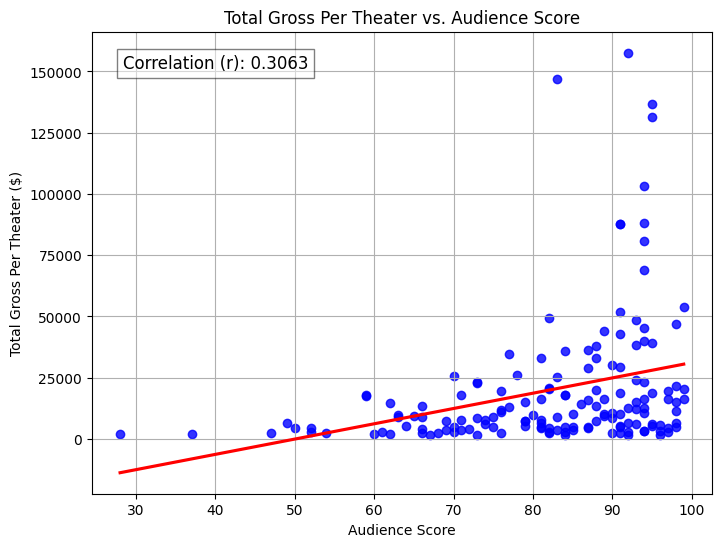

Regression statistics:
Intercept: -126505787.5426
Slope: 2387959.0536
R-squared: 0.0807
Correlation (Pearson's r): 0.2841
P-value: 0.0004
Standard error: 657899.9607


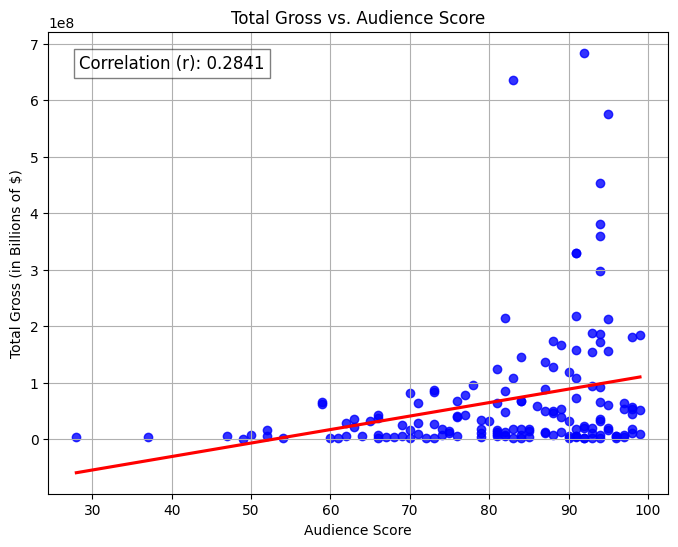

In [44]:
# regress_and_plot(working, 'audience_score', 'gross')
# regress_and_plot(working, 'audience_score', 'total gross')
regress_and_plot(working, 'audience_score', 'total_gross_per_theater', title='Total Gross Per Theater vs. Audience Score', xlabel = 'Audience Score', ylabel='Total Gross Per Theater ($)')
regress_and_plot(working, 'audience_score', 'total gross', title='Total Gross vs. Audience Score', xlabel = 'Audience Score', ylabel='Total Gross (in Billions of $)')

140
Regression statistics:
Intercept: -8298.7273
Slope: 264.0295
R-squared: 0.0942
Correlation (Pearson's r): 0.3069
P-value: 0.0002
Standard error: 69.7054


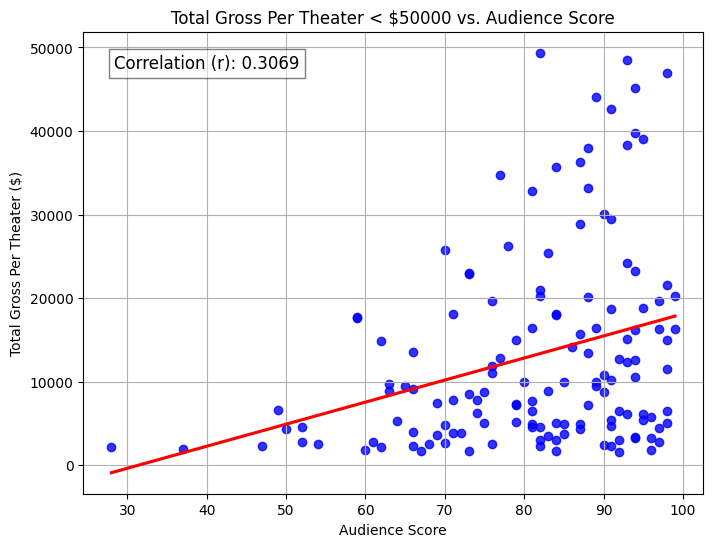

Regression statistics:
Intercept: 7.1877
Slope: 0.0233
R-squared: 0.1204
Correlation (Pearson's r): 0.3470
P-value: 0.0000
Standard error: 0.0054


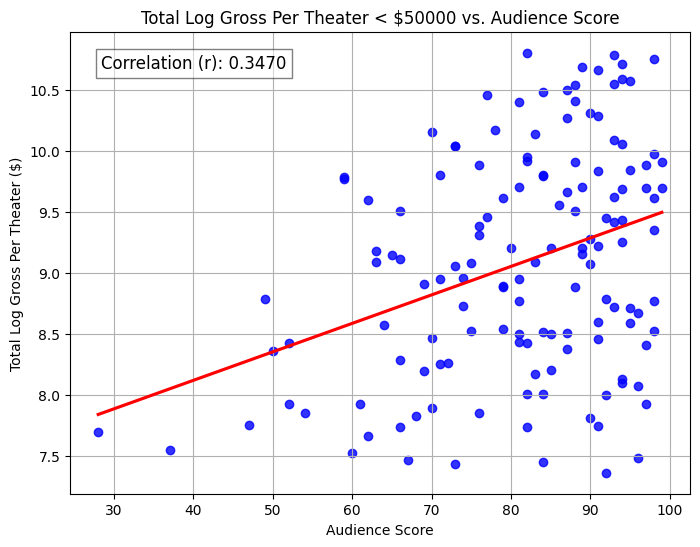

Regression statistics:
Intercept: 6.5932
Slope: 0.0326
R-squared: 0.1629
Correlation (Pearson's r): 0.4037
P-value: 0.0000
Standard error: 0.0060


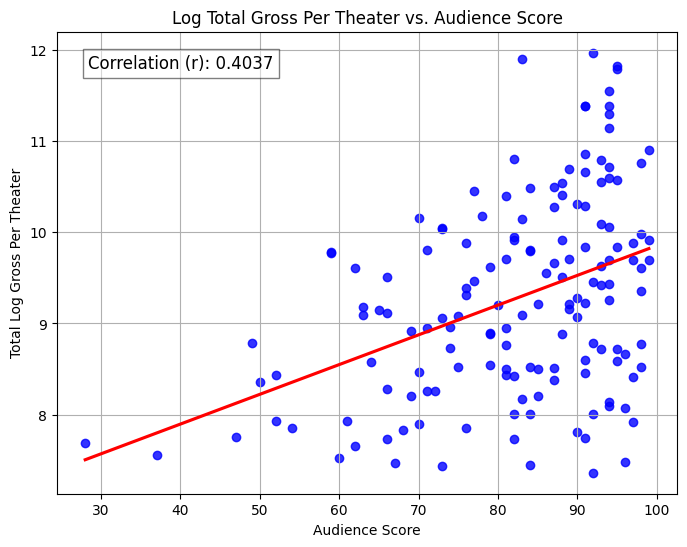

In [75]:
cutoff = 50000
print(len(working[working['total_gross_per_theater'] < cutoff]))
regress_and_plot(working[working['total_gross_per_theater'] < cutoff], 'audience_score', 'total_gross_per_theater', title = f'Total Gross Per Theater < ${cutoff} vs. Audience Score', xlabel = 'Audience Score', ylabel='Total Gross Per Theater ($)')
regress_and_plot(working[working['total_gross_per_theater'] < cutoff], 'audience_score', 'log_total_gross_per_theater', title = f'Total Log Gross Per Theater < ${cutoff} vs. Audience Score', xlabel = 'Audience Score', ylabel='Total Log Gross Per Theater ($)')
regress_and_plot(working, 'audience_score', 'log_total_gross_per_theater', title = f'Log Total Gross Per Theater vs. Audience Score', xlabel = 'Audience Score', ylabel='Total Log Gross Per Theater')

Regression statistics:
Intercept: 20965880.3009
Slope: 699602.1374
R-squared: 0.0193
Correlation (Pearson's r): 0.1391
P-value: 0.0875
Standard error: 406739.3936


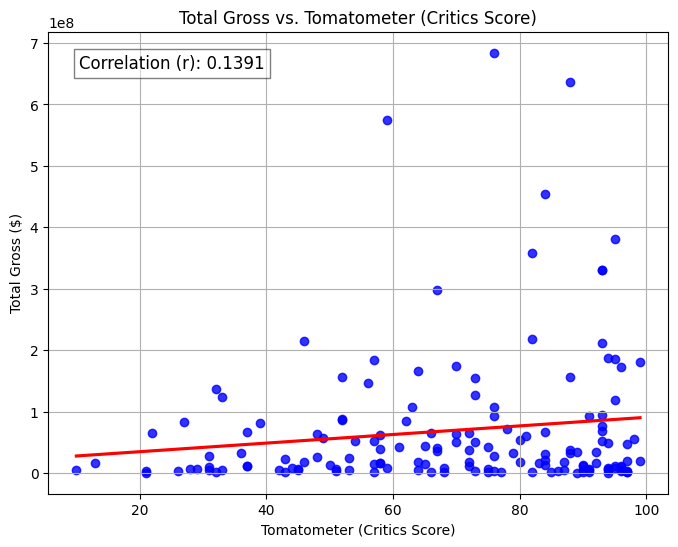

Regression statistics:
Intercept: 4022.6937
Slope: 229.7714
R-squared: 0.0355
Correlation (Pearson's r): 0.1884
P-value: 0.0201
Standard error: 97.8115


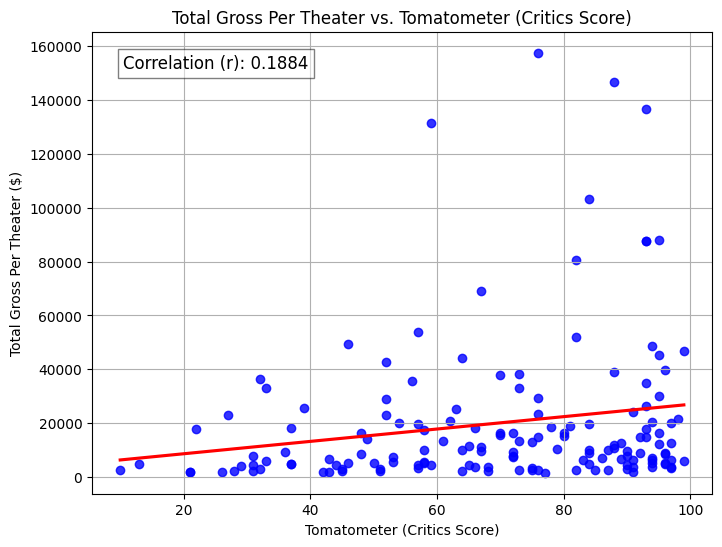

Regression statistics:
Intercept: 8277.4166
Slope: 70.9635
R-squared: 0.0192
Correlation (Pearson's r): 0.1387
P-value: 0.1023
Standard error: 43.1437


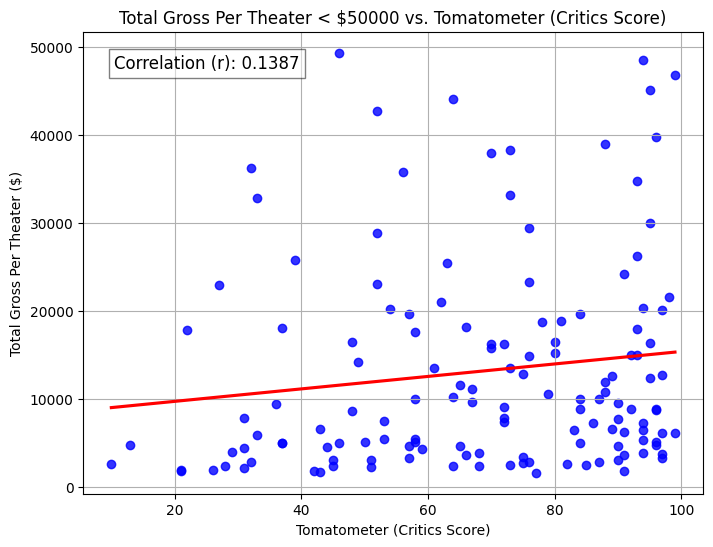

Regression statistics:
Intercept: 8.3893
Slope: 0.0127
R-squared: 0.0689
Correlation (Pearson's r): 0.2624
P-value: 0.0011
Standard error: 0.0038


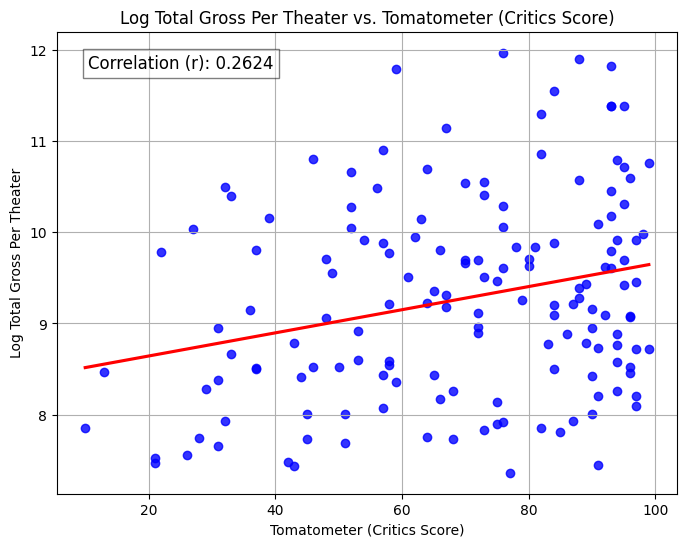

In [74]:
regress_and_plot(working, 'tomatometer', 'total gross', title = f'Total Gross vs. Tomatometer (Critics Score)', xlabel = 'Tomatometer (Critics Score)', ylabel='Total Gross ($)')
regress_and_plot(working, 'tomatometer', 'total_gross_per_theater', title = f'Total Gross Per Theater vs. Tomatometer (Critics Score)', xlabel = 'Tomatometer (Critics Score)', ylabel='Total Gross Per Theater ($)')
regress_and_plot(working[working['total_gross_per_theater'] < cutoff], 'tomatometer', 'total_gross_per_theater', title = f'Total Gross Per Theater < ${cutoff} vs. Tomatometer (Critics Score)', xlabel = 'Tomatometer (Critics Score)', ylabel='Total Gross Per Theater ($)')
regress_and_plot(working, 'tomatometer', 'log_total_gross_per_theater', title = f'Log Total Gross Per Theater vs. Tomatometer (Critics Score)', xlabel = 'Tomatometer (Critics Score)', ylabel='Log Total Gross Per Theater')
#


In [32]:
sum(working['rank'] < 50)
sum(working['rank'] > 50)
working.describe()
len(working[working['total gross'] < 50*10**6])


95

In [37]:
import matplotlib.pyplot as plt

def plot_histogram(df, column, title=None, xlabel=None, ylabel=None):
    """
    Function to plot a histogram of a specified variable in a pandas DataFrame.

    Parameters:
    df (pandas.DataFrame): The DataFrame containing the data
    column (str): The column in the DataFrame to plot
    title (str): The title of the plot (default is None)
    xlabel (str): The label for the x-axis (default is None)
    ylabel (str): The label for the y-axis (default is None)
    """
    plt.figure(figsize=(10, 6))
    plt.hist(df[column], bins=30, edgecolor='black', alpha=0.7)  # No need for dropna()

    # Set the title, xlabel, and ylabel if provided
    if title:
        plt.title(title)
    if xlabel:
        plt.xlabel(xlabel)
    if ylabel:
        plt.ylabel(ylabel)
    else:
        plt.ylabel('Frequency')  # Default y-axis label if none is provided

    plt.grid(True)
    plt.show()


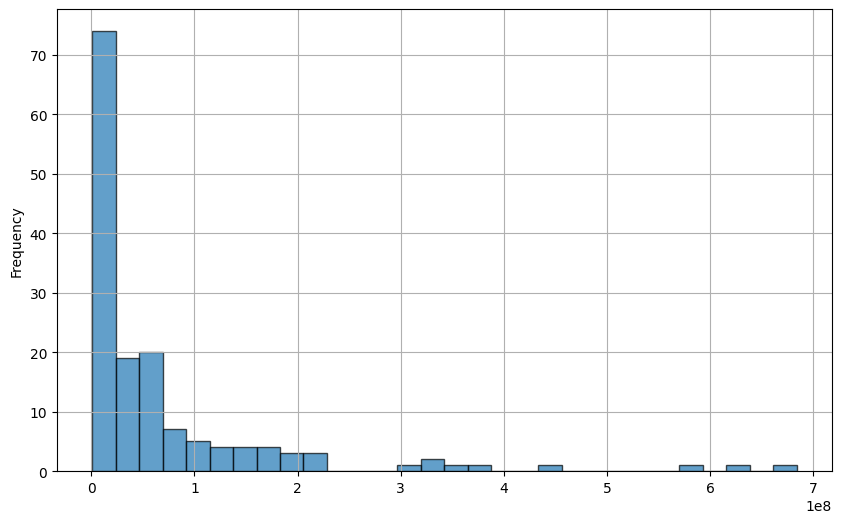

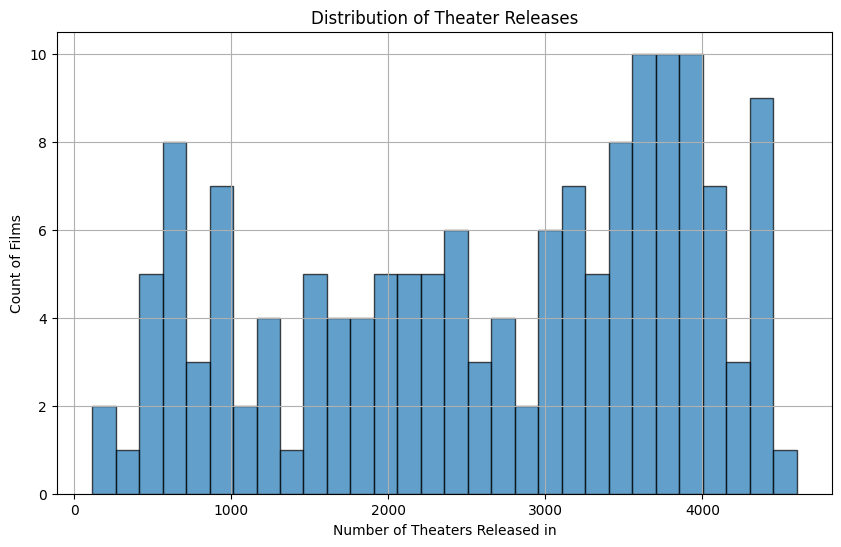

In [40]:
plot_histogram(working, 'total gross', title=None, xlabel=None, ylabel=None)

plot_histogram(working, 'theaters', title='Distribution of Theater Releases', xlabel='Number of Theaters Released in', ylabel='Count of Films')

In [ ]:
# a = merged[merged['gross'].isnull() | merged['audience_score'].isnull()]['movie_title']
merged[merged['gross'].isnull()]['movie_title'] # list 1

# for i in merged[merged['audience_score'].isnull()]['movie_title']: # list 2
#     print(i)

## check what's in merged that's not in result
# result[result['best_match'].isin('')]

## check what's in result that's not in merged


In [28]:
merged[merged['movie_title'].str.contains('Ant-Man', case = False, na = False)]

,rank,movie_title,gross,theaters,total gross,release date,distributor,estimated,tomatometer,audience_score,weighted_score,duration,year_released,url,num_of_reviews
13,8.0,Ant-Man and the Wasp: Quantumania,214504909.0,4345,214504909.0,Feb 17,Walt Disney Studios Motion Pictures,False,46.0,82.0,58.0,2h 4m,2023,https://www.rottentomatoes.com/m/ant_man_and_t...,413.0


In [ ]:
import pandas as pd
from rapidfuzz import process, fuzz

# Sample DataFrames
# df1 = pd.DataFrame({'Title': ['Inception', 'The Matrix', 'Pulp Fiction', 'Avengers: Endgame']})
# df2 = pd.DataFrame({'Title': ['Inception', 'Matrix', 'Pulp Fiction', 'Avengers Endgame', 'The Lion King']})

# Function to perform fuzzy matching
def fuzzy_merge(df_1, df_2, key1, key2, threshold=90, limit=1):
    """
    df_1: DataFrame with the first set of movie titles
    df_2: DataFrame with the second set of movie titles
    key1: Column name in df_1 to match on
    key2: Column name in df_2 to match against
    threshold: Score threshold for fuzzy matching (0-100)
    limit: Number of matches to return for each item
    """
    # Convert the column to a list for processing
    s = df_2[key2].tolist()
    
    # Apply the fuzzy matching process
    matches = df_1[key1].apply(lambda x: process.extract(x, s, scorer=fuzz.ratio, limit=limit))
    
    # Extract the top matches with score above the threshold
    df_1['matches'] = matches
    df_1['best_match'] = df_1['matches'].apply(lambda x: x[0][0] if x[0][1] >= threshold else None)
    df_1['match_score'] = df_1['matches'].apply(lambda x: x[0][1] if x[0][1] >= threshold else None)
    
    # Merge the dataframes on the best match
    merged_df = df_1.merge(df_2, left_on='best_match', right_on=key2, how='left', suffixes=('_df1', '_df2'))
    
    return merged_df, df_1, df_2

# Using the function to merge
result, mojo, rt = fuzzy_merge(mojo, rt, 'movie_title', 'movie_title', threshold=80)
# print(result)
